# Libraries

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from omegaconf import OmegaConf
from src.models import models
from src.models import model as mainmodel
from src.models import modelConv2d
from src.models import modelineal
from src import loss_func
from src import train
from src import loader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from src import optimizer_Factory as of
import Data.genData as genData
from src import custom_plots as cp
from src import Visual_utils as vu
import torchvision

import wandb
import random

# Pendulum

### Load Data

In [10]:
g=9.81
L=1
x0=np.pi/2
x1=np.pi/2.5
t,a = genData.generatePendulumA(g,L,x0, x1)

<Figure size 640x480 with 0 Axes>

In [11]:
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a)

### Visualizations

In [12]:
img = genData.create_pendulum_image(90)
print("Image shape:", img.size)
genData.generateVideo()

Image shape: (500, 260)


<Figure size 640x480 with 0 Axes>

In [13]:
genData.generateVideo()

<Figure size 640x480 with 0 Axes>

In [7]:
###### uncoment to see dataset example  ######

# data_iter = iter(train_dataloader)

# # Get a batch of data
# batch_data = next(data_iter)

# # Get the shape of the batch
# batch_shape = batch_data[0][0].shape

# print("Batch shape:", batch_shape)

# testimage = batch_data[0][0][0]
# cmap = plt.cm.get_cmap('Greys_r', 256)

# # set gray colormap imshow
# plt.figure()
# plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')
# testimage = batch_data[0][0][29]
# # set gray colormap imshow
# plt.figure()
# plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')
# testimage = batch_data[0][0][30]
# # set gray colormap imshow
# plt.figure()
# plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')
# testimage = batch_data[0][0][31]
# # set gray colormap imshow
# plt.figure()
# plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')

#cp.plotMatrix(testimage.permute(1, 2, 0),'xlabel', 'ylabel','title', 'name', styleDark = True)

In [69]:
###### uncoment to see dataset example  ######
# im1 = genData.create_pendulum_image(0.1)
# print("Image shape:", im1.size)
# plt.figure()
# plt.imshow(im1)
# from torchvision import transforms
# convert_tensor = transforms.ToTensor()

# tensor_image = convert_tensor(im1)
# # Print tensor image shape
# print("Tensor image shape:", tensor_image.shape)
# # print max value torch tensor
# print("Max value:", torch.max(tensor_image))
# plt.figure()
# plt.imshow(  tensor_image.permute(1, 2, 0)  )

### Visualization 3D dataset

Batch shape: torch.Size([32, 3, 260, 500])
torch.Size([3, 260, 500])
torch.Size([1, 260, 500])


/tmp/ipykernel_4095/685028545.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Greys_r', 256)
/tmp/ipykernel_4095/685028545.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Greys_r', 256)


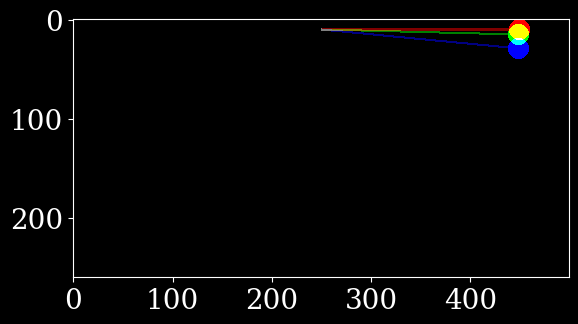

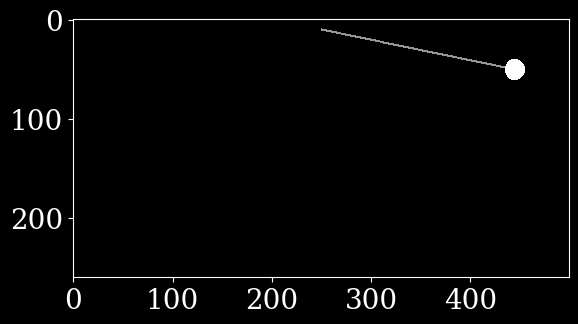

In [10]:
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a)

data_iter = iter(train_dataloader)

# Get a batch of data
batch_data = next(data_iter)


# Get the shape of the batch
batch_shape = batch_data[0].shape

print("Batch shape:", batch_shape)

testimage = batch_data[0][0,:,:,:]
cmap = plt.cm.get_cmap('Greys_r', 256)

print(testimage.shape)

# set gray colormap imshow
plt.figure()
plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')

testimage = batch_data[1][0,:,:,:]
cmap = plt.cm.get_cmap('Greys_r', 256)

print(testimage.shape)

# set gray colormap imshow
plt.figure()
plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')


### Model Conv3D

In [11]:

#train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a)
modelAE = models.AE(dt=1/30, initw=True)
modelAE, train_losses, val_losses, accuracy_list  = train.train(modelAE, train_dataloader, test_dataloader, 'GNNSimple')

IndexError: list index out of range

#### Visual Test

In [12]:
visual_loader= loader.getLoader(a, split=False)

In [13]:
vu.visualize(modelAE, visual_loader)

NameError: name 'modelAE' is not defined

<Figure size 640x480 with 0 Axes>

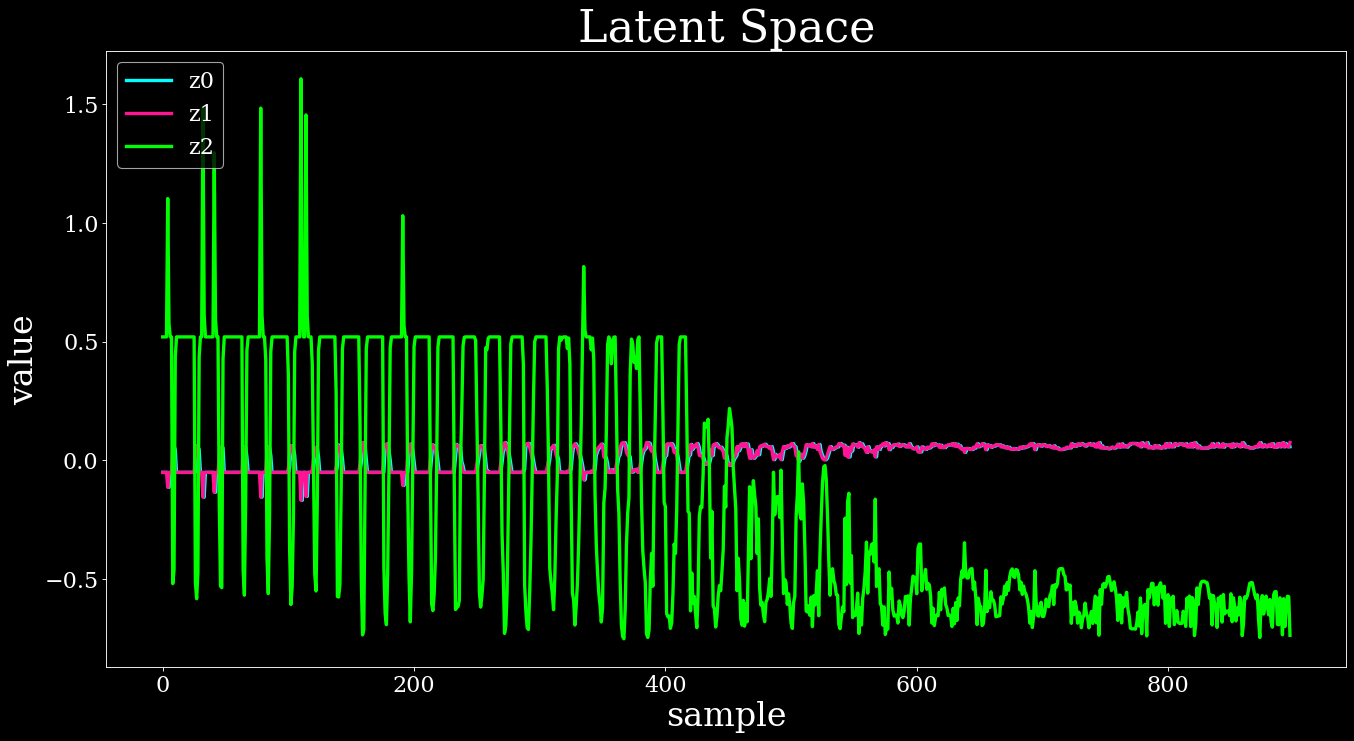

In [44]:
vu.CompareLatent(modelAE, visual_loader)

### Model Conv2d

Using device: cuda
epoch: 2 	 training loss: 0.0077855517561344996 	 validation loss: 0.0077446250555415945
epoch: 4 	 training loss: 0.0077281988468831 	 validation loss: 0.007719971550007661
epoch: 6 	 training loss: 0.007672971094270115 	 validation loss: 0.007598207254583637
epoch: 8 	 training loss: 0.007497677316322275 	 validation loss: 0.007370046727980177
epoch: 10 	 training loss: 0.007421899202239254 	 validation loss: 0.007237184404705961
epoch: 12 	 training loss: 0.007380851584932078 	 validation loss: 0.007119542142997186
epoch: 14 	 training loss: 0.007324234825437484 	 validation loss: 0.007006919709965587
epoch: 16 	 training loss: 0.007293946393158125 	 validation loss: 0.0069684806900719804
epoch: 18 	 training loss: 0.0072872305045957155 	 validation loss: 0.0069409022107720375
epoch: 20 	 training loss: 0.007260584069982819 	 validation loss: 0.006903703790158033


<Figure size 640x480 with 0 Axes>

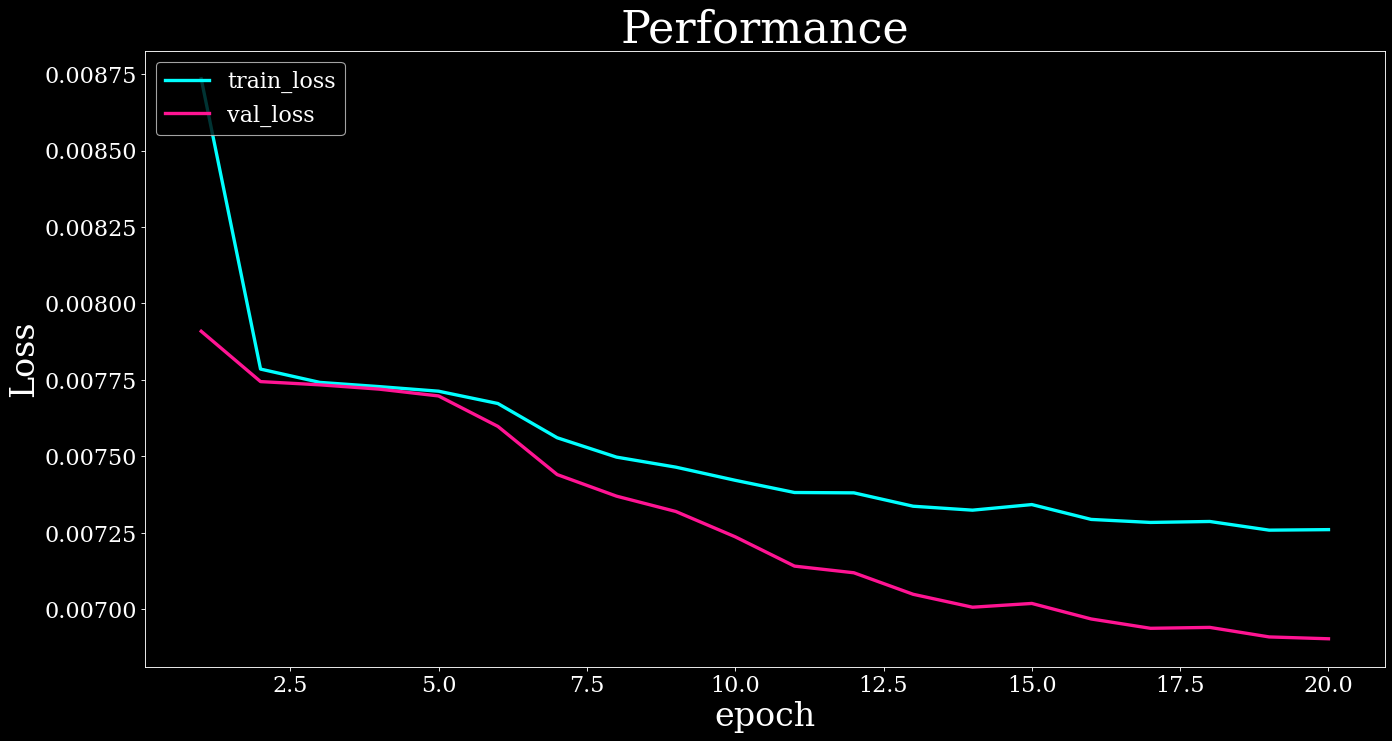

In [6]:
modelAE = modelConv2d.AE(dt=1/30, initw=True)
modelAE, train_losses, val_losses, accuracy_list  = train.train(modelAE, train_dataloader, test_dataloader, 'GNNSimple')

In [7]:
visual_loader= loader.getLoader(a, split=False)

In [12]:
vu.visualize(modelAE, visual_loader, video_name = 'Conv2d_ExpVsPred.mp4')

Video saved as Conv2d_ExpVsPred.mp4


<Figure size 640x480 with 0 Axes>

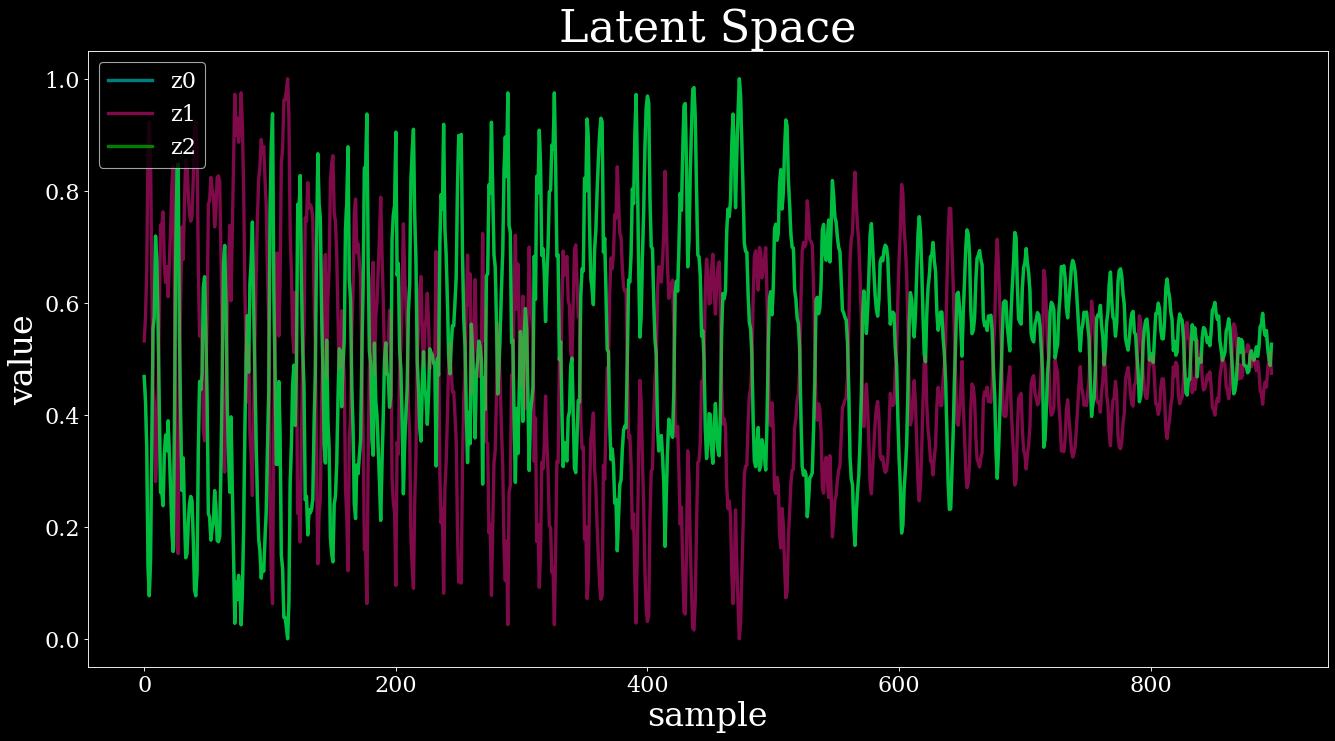

In [11]:
vu.CompareLatent(modelAE, visual_loader)

### Model Lineal

Using device: cuda
epoch: 2 	 training loss: 0.007626414258518945 	 validation loss: 0.007330852948750059
epoch: 4 	 training loss: 0.007281827092494654 	 validation loss: 0.006999196562295158
epoch: 6 	 training loss: 0.007255601271501054 	 validation loss: 0.006856800289824605
epoch: 8 	 training loss: 0.00723997979303417 	 validation loss: 0.006830619104827444
epoch: 10 	 training loss: 0.0072318640051652556 	 validation loss: 0.006821838750814398
epoch: 12 	 training loss: 0.007226657972711584 	 validation loss: 0.006815505136425297
epoch: 14 	 training loss: 0.0072232803289333115 	 validation loss: 0.006811484151209394
epoch: 16 	 training loss: 0.007221025718457025 	 validation loss: 0.006808608304709196
epoch: 18 	 training loss: 0.0072194128904653635 	 validation loss: 0.006806049185494582
epoch: 20 	 training loss: 0.007217927795389424 	 validation loss: 0.006803764263167977


<Figure size 640x480 with 0 Axes>

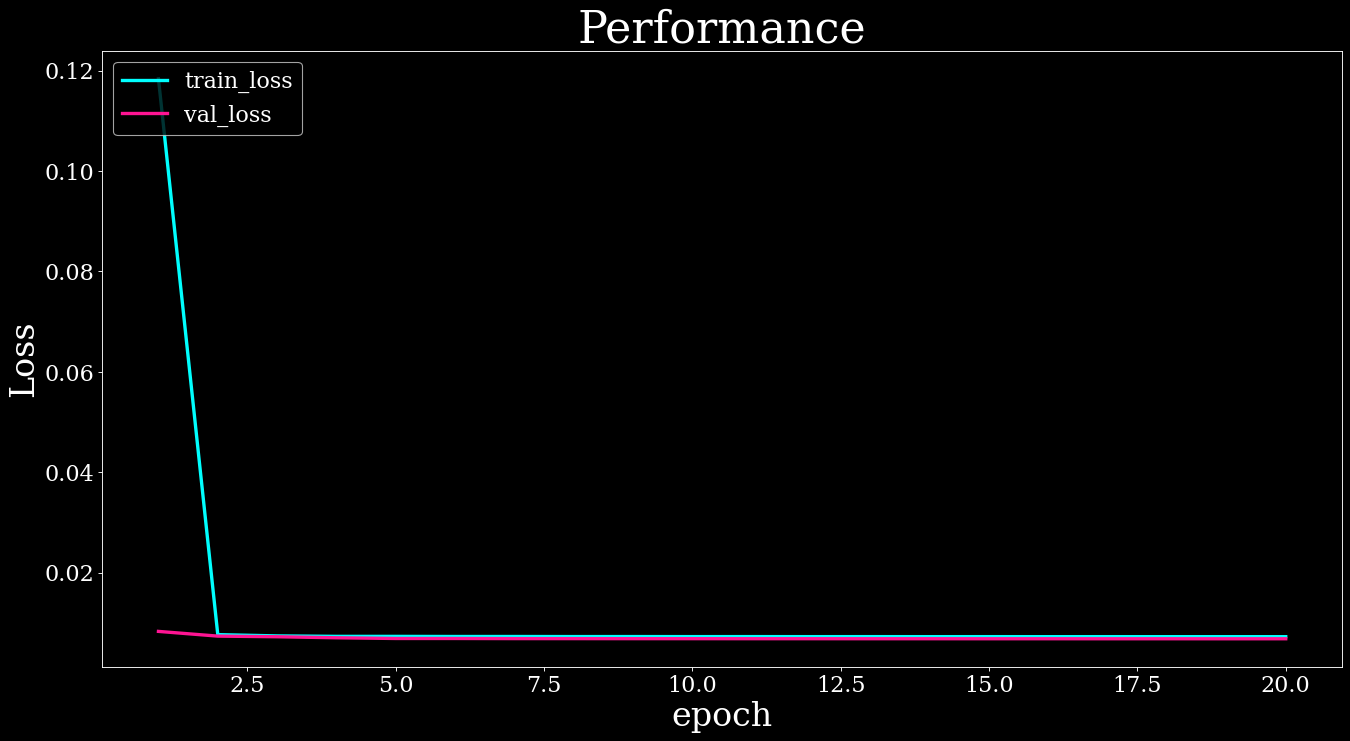

In [21]:
linealmodel = modelineal.AE(dt=1/30, initw=True)
linealmodel, train_losses, val_losses, accuracy_list  = train.train(linealmodel, train_dataloader, test_dataloader, 'LinelModel')

In [22]:
visual_loader= loader.getLoader(a, split=False)

In [23]:
vu.visualize(linealmodel, visual_loader, video_name = 'LinealModel_ExpVsPred.mp4')

Video saved as LinealModel_ExpVsPred.mp4


<Figure size 640x480 with 0 Axes>

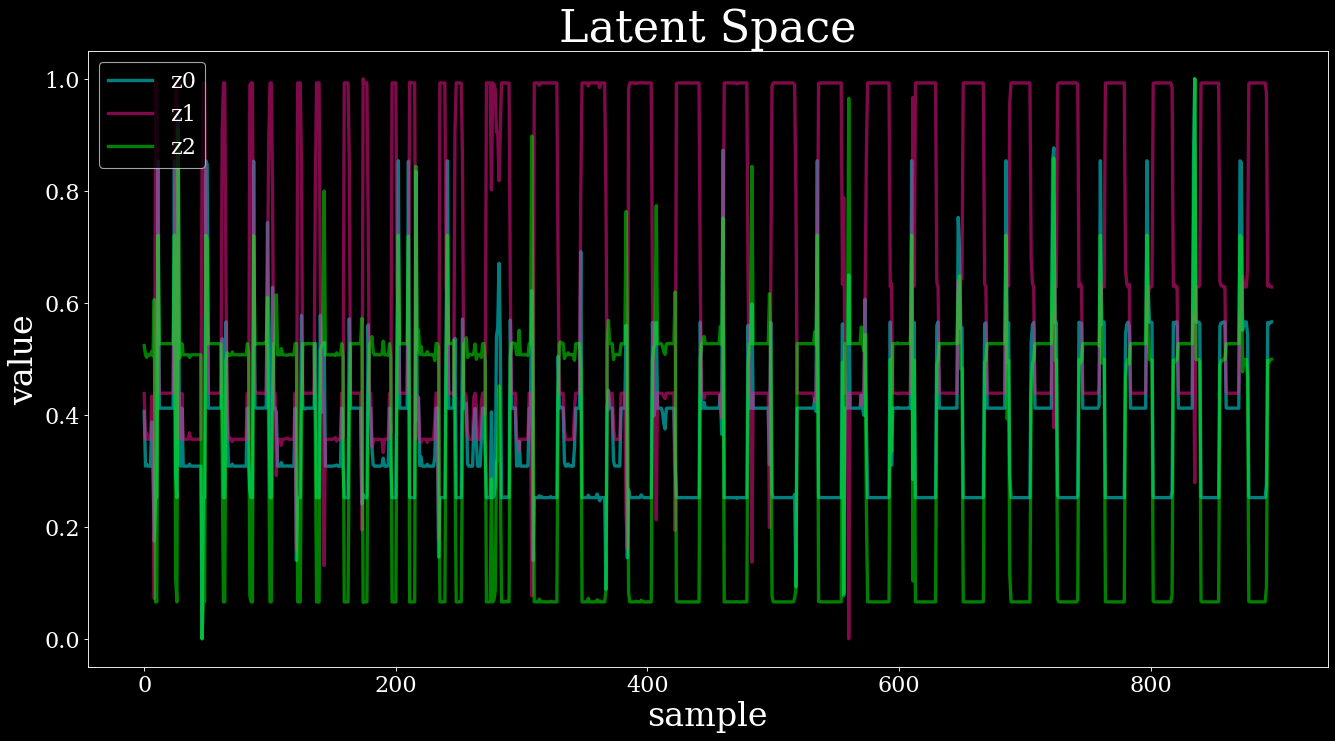

In [24]:
vu.CompareLatent(linealmodel, visual_loader, name='latentSapce_LinealModel.png')

### Test Decoder

In [14]:
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a, type = "Dataset_decoder")
visual_loader= loader.getLoader(a, split=False, type = "Dataset_decoder")

#### Linear

In [28]:
linearDecoder = modelineal.Decoder(initw=True)

Using device: cpu
epoch: 2 	 training loss: 0.012668797665316126 	 validation loss: 0.03200358214477698
epoch: 4 	 training loss: 0.00900071353206168 	 validation loss: 0.021262341334174078
epoch: 6 	 training loss: 0.007649606164625805 	 validation loss: 0.016277366628249485
epoch: 8 	 training loss: 0.006776542817849828 	 validation loss: 0.013157925102859735
epoch: 10 	 training loss: 0.006187784029980717 	 validation loss: 0.011080001015216112
epoch: 12 	 training loss: 0.005783648878012014 	 validation loss: 0.009720661832640568
epoch: 14 	 training loss: 0.005460187985116373 	 validation loss: 0.00869740848429501
epoch: 16 	 training loss: 0.0052258714770331335 	 validation loss: 0.007926780342434844
epoch: 18 	 training loss: 0.005056387846074675 	 validation loss: 0.007354445212210218
epoch: 20 	 training loss: 0.004899973717882582 	 validation loss: 0.006867084264134367


FileNotFoundError: [Errno 2] No such file or directory: './plots/.Results/linearDecoder.png'

<Figure size 640x480 with 0 Axes>

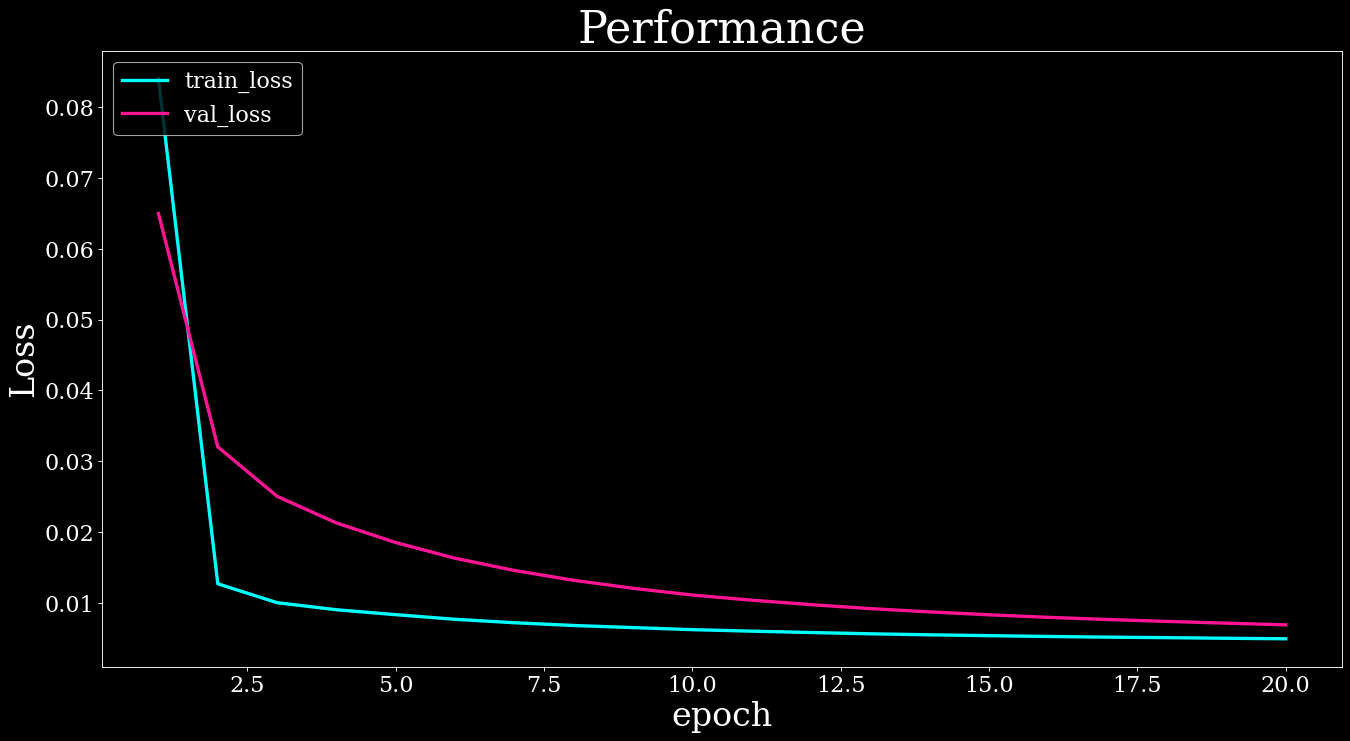

In [29]:

linearDecoder, train_losses, val_losses, accuracy_list  = train.train(linearDecoder, train_dataloader, test_dataloader, '../Results/linearDecoder', loss_name='decoder_loss')

In [31]:
vu.visualize_dec(linearDecoder, visual_loader, video_name = './Results/LinearDecoder_ExpVsPred.mp4')

Video saved as ./Results/LinearDecoder_ExpVsPred.mp4


#### Conv2D

In [15]:
con2dDecoder = modelConv2d.FullDecoder(initw=True)
con2dDecoder, train_losses, val_losses, accuracy_list  = train.train(con2dDecoder, train_dataloader, test_dataloader, 'con2dDecoder', loss_name='Focal_batch_loss')

Using device: cpu


IndexError: Dimension out of range (expected to be in range of [-3, 2], but got 3)

In [13]:
vu.visualize_dec(con2dDecoder, visual_loader, video_name = 'con2dDecoder.mp4')

Video saved as con2dDecoder.mp4


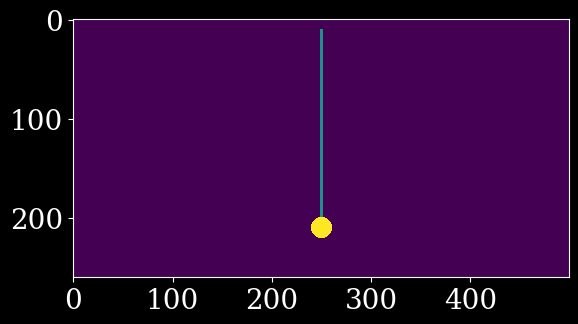

In [16]:
template = genData.create_pendulum_image(0)

plt.figure()    
plt.imshow(template,interpolation='nearest')

In [48]:

import torchvision.transforms as transforms

train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a, type = "Dataset_decoder")
visual_loader= loader.getLoader(a, split=False, type = "Dataset_decoder")

device = "cuda" if torch.cuda.is_available() else "cpu"
transform = transforms.Compose([
    transforms.PILToTensor()
])
transform =  transforms.ToTensor()
template = genData.create_pendulum_image(0)
template = transform(template).to(device)

print(type(template))
print(template.dtype)


ConvAE = modelConv2d.ConvAE(template=template, initw=True)
ConvAE, train_losses, val_losses, accuracy_list  = train.train(ConvAE, train_dataloader, test_dataloader, 'ConvAE', loss_name='ConvAE_decoder_loss')

<class 'torch.Tensor'>
torch.float32
Using device: cpu
x: torch.Size([32, 12, 61, 121])  d3: torch.Size([1, 12, 32, 62])


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 122 but got size 32 for tensor number 1 in the list.

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

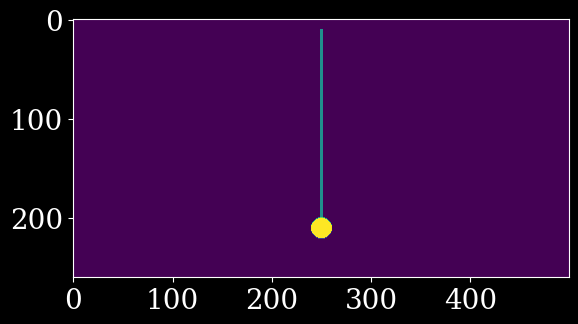

In [14]:
loader.get_template()

In [39]:
x = torch.tensor([1, 2, 3])
print(x, x.shape)
x = x.unsqueeze(0)
print(x, x.shape)
x = x.repeat(4,2)
print(x, x.shape)

tensor([1, 2, 3]) torch.Size([3])
tensor([[1, 2, 3]]) torch.Size([1, 3])
tensor([[1, 2, 3, 1, 2, 3],
        [1, 2, 3, 1, 2, 3],
        [1, 2, 3, 1, 2, 3],
        [1, 2, 3, 1, 2, 3]]) torch.Size([4, 6])


# Neuron

In [39]:

t,a = genData.generateIntensity()
train_dataloader, test_dataloader, train_x, val_x  = loader.getLoaderIn(a,split = True, type = "Dataset3d",  dt=1/100, nInFrames = 3,sr = 10 ,  noise=False, shapeType='simple')
print(train_x.shape)
print(val_x.shape)
print(len(train_dataloader))
print(len(test_dataloader))

(1600,)
(400,)
50
12


<Figure size 640x480 with 0 Axes>

(2000,)


<function matplotlib.pyplot.show(close=None, block=None)>

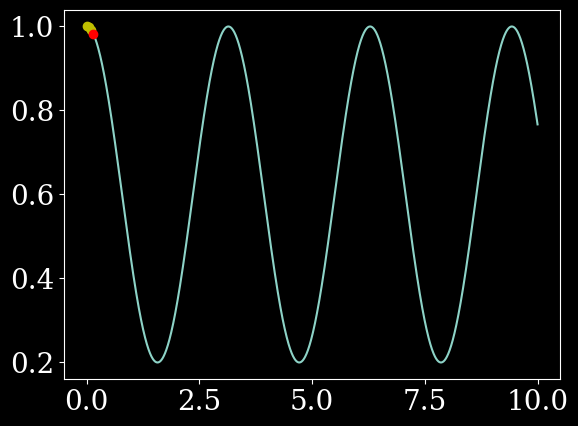

In [37]:
print(a.shape)

plt.figure()
plt.plot(t,a)
sr = 10
for i in range(4):
    if i == 3:
        plt.plot(t[i*sr],a[i*sr],'ro')
    else:
        plt.plot(t[i*sr],a[i*sr],'yo')

plt.show

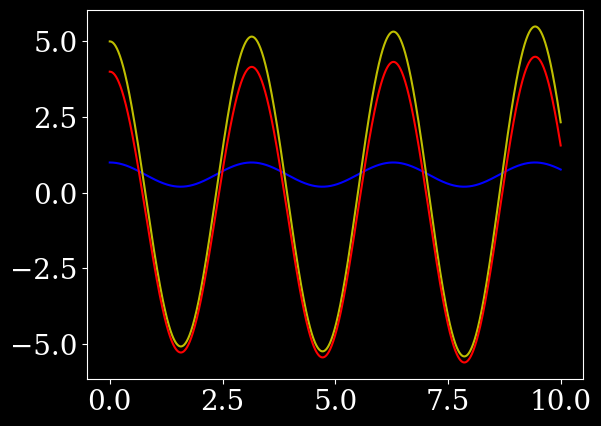

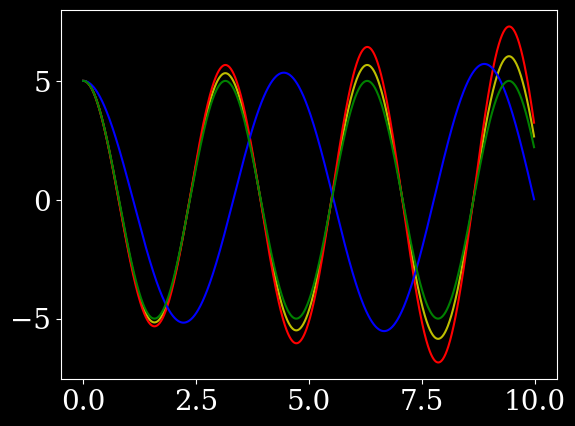

In [30]:
yd = np.zeros(2000)
yd[0]= a[0]*5
yd[1] = a[1]*5
yd[2] = a[2]*5

dt = 1/200

for i in range(2000-3):

    y0 = yd[i]
    y1 = yd[i+1]
    y2 = yd[i+2]

    yd[i+3] = y2 + (y2-y1) + dt*dt*(-4*y1)

plt.figure()
plt.plot(t,a,'b')
plt.plot(t,yd,'y')
plt.plot(t,yd-a,'r')
plt.show()

yd = np.zeros(1000)
td = np.zeros(1000)

td[0]= t[0]
td[1] = t[2]
td[2] = t[4]

yd[0]= a[0]*5
yd[1] = a[2]*5
yd[2] = a[4]*5

dt = 2/200

for i in range(1000-3):

    y0 = yd[i]
    y1 = yd[i+1]
    y2 = yd[i+2]

    yd[i+3] = y2 + (y2-y1) + dt*dt*(-4*y1)

    td[i+3] = td[i+2] + dt

plt.figure()

plt.plot(td,yd,'y')

yd = np.zeros(1000)
td = np.zeros(1000)

td[0]= t[0]
td[1] = t[2]
td[2] = t[4]

yd[0]= a[0]*5
yd[1] = a[2]*5
yd[2] = a[4]*5

dt = 2/200

for i in range(1000-3):

    y0 = yd[i]
    y1 = yd[i+1]
    y2 = yd[i+2]

    yd[i+3] = y2 + (y2-y1) + dt*dt*(-4*y0)

    td[i+3] = td[i+2] + dt
plt.plot(td,yd,'r')

yd = np.zeros(1000)
td = np.zeros(1000)

td[0]= t[0]
td[1] = t[2]
td[2] = t[4]

yd[0]= a[0]*5
yd[1] = a[2]*5
yd[2] = a[4]*5

dt = 2/200

for i in range(1000-3):

    y0 = yd[i]
    y1 = yd[i+1]
    y2 = yd[i+2]

    yd[i+3] = y2 + (y1-y0) + dt*dt*(-4*y0)

    td[i+3] = td[i+2] + dt
plt.plot(td,yd,'b')

yd = np.zeros(1000)
td = np.zeros(1000)

td[0]= t[0]
td[1] = t[2]
td[2] = t[4]

yd[0]= a[0]*5
yd[1] = a[2]*5
yd[2] = a[4]*5

dt = 2/200

for i in range(1000-3):

    y0 = yd[i]
    y1 = yd[i+1]
    y2 = yd[i+2]

    yd[i+3] = y2 + (y2-y1) + dt*dt*(-4*y2)

    td[i+3] = td[i+2] + dt
plt.plot(td,yd,'g')

plt.show()
    

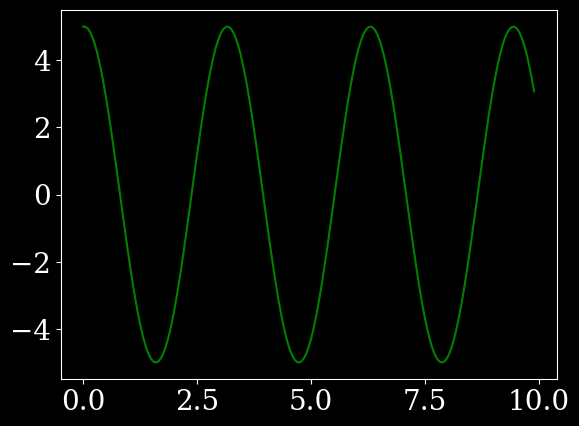

In [38]:
yd = np.zeros(200)
td = np.zeros(200)

td[0]= t[0]
td[1] = t[10]
td[2] = t[10]

yd[0]= a[0]*5
yd[1] = a[10]*5
yd[2] = a[10]*5

dt = 10/200

for i in range(200-3):

    y0 = yd[i]
    y1 = yd[i+1]
    y2 = yd[i+2]

    yd[i+3] = y2 + (y2-y1) + dt*dt*(-4*y2)

    td[i+3] = td[i+2] + dt
plt.plot(td,yd,'g')

plt.show()

### Visuals

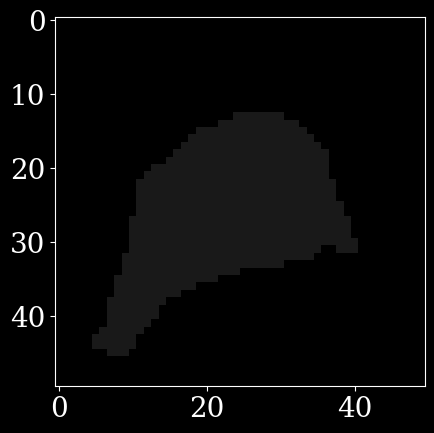

In [6]:
aa = genData.create_intensity_image(0.1, noise=False, shapeType='simple' )

plt.figure()
plt.imshow(aa, cmap='gray', vmax=1, vmin=0)


Batch shape: torch.Size([32, 3, 50, 50])
torch.Size([3, 50, 50])
torch.Size([1, 50, 50])


/var/folders/wk/_mh2wz7s0zn4v3ldz4ml80s00000gq/T/ipykernel_3061/217011701.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Greys_r', 256)
/var/folders/wk/_mh2wz7s0zn4v3ldz4ml80s00000gq/T/ipykernel_3061/217011701.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Greys_r', 256)


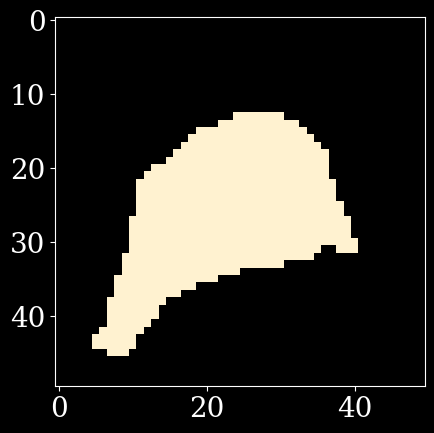

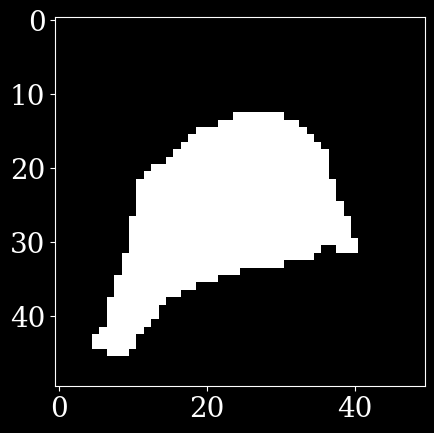

In [7]:
data_iter = iter(train_dataloader)

# Get a batch of data
batch_data = next(data_iter)


# Get the shape of the batch
batch_shape = batch_data[0].shape

print("Batch shape:", batch_shape)

testimage = batch_data[0][0,:,:,:]
cmap = plt.cm.get_cmap('Greys_r', 256)

print(testimage.shape)

# set gray colormap imshow
plt.figure()
plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')

testimage = batch_data[1][30,:,:,:]
cmap = plt.cm.get_cmap('Greys_r', 256)

print(testimage.shape)

# set gray colormap imshow
plt.figure()
plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')

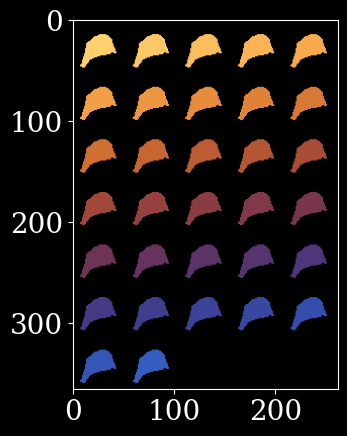

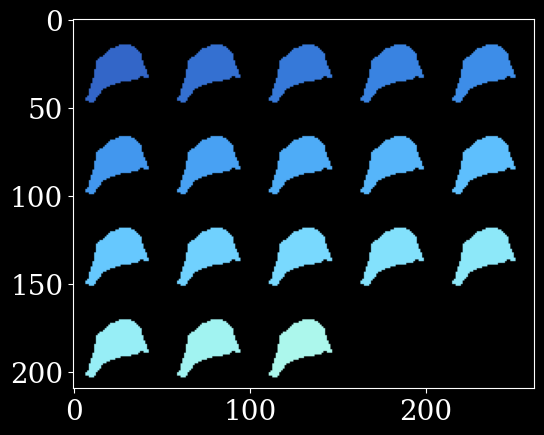

In [8]:
data_iter = iter(train_dataloader)

# Get a batch of data
batch_data = next(data_iter)

for data in train_dataloader:

    grid_img = torchvision.utils.make_grid(data[0], nrow=5)

    plt.figure()

    plt.imshow(grid_img.permute(1, 2, 0))

### Model

In [5]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:2000"
torch.cuda.empty_cache() 

torch.manual_seed(42)

In [6]:
a[::50]

array([1.        , 0.95103302, 0.81612092, 0.62829488, 0.43354127,
       0.27954255, 0.204003  , 0.22541733, 0.33854255, 0.51568168,
       0.71346487, 0.88346791, 0.98406811, 0.99063505, 0.9015609 ,
       0.73865413, 0.54179999, 0.35919524, 0.2355479 , 0.20113114,
       0.26437139, 0.40978523, 0.60177028, 0.7933219 , 0.93754158,
       0.99911931, 0.96297871, 0.83796827, 0.65469489, 0.45803029,
       0.29612483, 0.20861861, 0.21693621, 0.31904118, 0.48993466,
       0.68777599, 0.86412668, 0.97580996, 0.99548185, 0.91832599])

In [7]:
print(a[50],a[100], a[150])

0.9510330247561491 0.8161209223472559 0.6282948806670812


In [45]:


modelfull= modelineal.AE(dt=0.05, initw=True)
#modelfull= mainmodel.AEModel(dt=0.25, initw=True)#
modelfull, train_losses, val_losses, accuracy_list  = train.train(modelfull, train_dataloader, test_dataloader, 'fullmodel', type='encoder-decoder')



Using device: cpu


torch.Size([32, 3])
tensor([[1.0000, 0.9980, 0.9920],
        [1.0000, 0.9976, 0.9912],
        [0.9999, 0.9971, 0.9904],
        [0.9998, 0.9966, 0.9895],
        [0.9997, 0.9961, 0.9885]])
tensor([[0.9761],
        [0.9749],
        [0.9737],
        [0.9724],
        [0.9711]])
torch.Size([32, 3])
tensor([[0.9797, 0.9652, 0.9471],
        [0.9784, 0.9636, 0.9451],
        [0.9771, 0.9619, 0.9431],
        [0.9757, 0.9602, 0.9410],
        [0.9744, 0.9584, 0.9389]])
tensor([[0.9195],
        [0.9172],
        [0.9148],
        [0.9124],
        [0.9100]])
torch.Size([32, 3])
tensor([[0.9208, 0.8954, 0.8670],
        [0.9184, 0.8927, 0.8640],
        [0.9160, 0.8899, 0.8610],
        [0.9135, 0.8872, 0.8579],
        [0.9110, 0.8844, 0.8549]])
tensor([[0.8299],
        [0.8267],
        [0.8234],
        [0.8201],
        [0.8168]])
torch.Size([32, 3])
tensor([[0.8294, 0.7955, 0.7597],
        [0.8261, 0.7920, 0.7561],
        [0.8228, 0.7885, 0.7524],
        [0.8195, 0.7850, 0.7487]

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


alpha,▁
beta,▁
train_loss,▁
validation_loss,▁
alpha,4.0
beta,0.0
train_loss,0.30237
validation_loss,0.2624


<Figure size 640x480 with 0 Axes>

In [10]:
for name, param in modelfull.named_parameters():
    print(name, param.shape, param.requires_grad)

print(modelfull.pModel.alpha[0])
print(modelfull.pModel.beta[0]) 

encoder.linear.0.weight torch.Size([1000, 2500]) True
encoder.linear.0.bias torch.Size([1000]) True
encoder.linear.1.weight torch.Size([500, 1000]) True
encoder.linear.1.bias torch.Size([500]) True
encoder.linear.2.weight torch.Size([1, 500]) True
encoder.linear.2.bias torch.Size([1]) True
decoder.l1.weight torch.Size([10, 1]) True
decoder.l2.weight torch.Size([1000, 10]) True
decoder.l3.weight torch.Size([2500, 1000]) True
pModel.alpha torch.Size([1]) False
pModel.beta torch.Size([1]) False
tensor(4.)
tensor(0.)


In [42]:
def phyModel(y1, y2, dt):
    alpha = 4
    return y2 + (y2-y1) - dt*dt*(alpha*y1)

print(phyModel( 0.9980, 0.9920, 0.05))

0.97602


In [44]:
print(0.9980 * 255)
print(0.97602*255)

254.49
248.8851


In [43]:
modelfull.pModel.alpha[0].detach().cpu().numpy()

array(4., dtype=float32)

In [44]:
modelfull.decoder.l1.weight.shape

torch.Size([100, 1])

In [45]:
visual_loader= loader.getLoaderIn(a,  split = False, type = "Dataset3d",  dt=0.05,nInFrames = 3,sr = 10 ,   noise=False, shapeType='simple')

In [46]:
vu.visualize(modelfull, visual_loader, video_name = 'neuronFullModel_ExpVsPred.mp4')

Video saved as neuronFullModel_ExpVsPred.mp4


In [47]:
vu.CompareLatent(modelfull, visual_loader)

/Users/Alejandro/Documents/PhD/Repositories/Mine/Vphy/src/Visual_utils.py:303: RuntimeWarning: divide by zero encountered in divide
  return (x - x.min()) / (x.max() - x.min())
/Users/Alejandro/Documents/PhD/Repositories/Mine/Vphy/src/Visual_utils.py:303: RuntimeWarning: invalid value encountered in divide
  return (x - x.min()) / (x.max() - x.min())


<Figure size 640x480 with 0 Axes>

In [40]:
print(modelfull.pModel.alpha)

plt.figure()
mask = modelfull.mask.to('cpu').detach().numpy().copy()
mask = np.squeeze(mask)
plt.imshow(mask, cmap='gray')
plt.colorbar()

Parameter containing:
tensor([4.])


AttributeError: 'AE' object has no attribute 'mask'

<Figure size 640x480 with 0 Axes>

# Test

In [21]:
# Assuming batch size is 32 and images are grayscale with dimensions (height, width)
batch_size = 32
height, width = 28, 28  # Example dimensions, adjust as per your images

# Generate a random batch of images (example)
batch_images = torch.rand(batch_size, height, width)

# Reshape the batch to (batch_size, num_pixels)
batch_images_flat = batch_images.view(batch_size, -1)

print(batch_images_flat.shape)
print(batch_images.shape)

# Calculate the variance across the batch for each pixel
variances = torch.var(batch_images_flat, dim=0)

print(variances.shape)

torch.Size([32, 784])
torch.Size([32, 28, 28])
torch.Size([784])


In [38]:


# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="my-awesome-project",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.02,
    "architecture": "CNN",
    "dataset": "CIFAR-100",
    "epochs": 10,
    }
)

# simulate training
epochs = 10
offset = random.random() / 5
for epoch in range(2, epochs):
    acc = 1 - 2 ** -epoch - random.random() / epoch - offset
    loss = 2 ** -epoch + random.random() / epoch + offset
    
    # log metrics to wandb
    wandb.log({"acc": acc, "loss": loss})
    
# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: alejandro_c. Use `wandb login --relogin` to force relogin


acc,▁▄▃▄▆███
loss,█▆▄▄▂▁▁▁
acc,0.84684
loss,0.10441


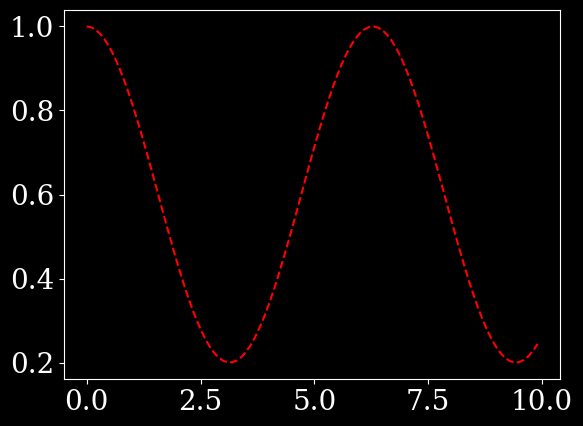

In [40]:
t = np.arange(0,10, 0.1)
m = (1-0.2)/(1-(-1))
b= 1 - m
x = m*np.cos(t)+b

y0 = x[0]
y1 = x[1]
y = np.zeros(len(t))
y[0] = y0
y[1] = y1
dt = 0.1
for i in range(2, len(t)):
    y2 = y1+ (y1-y0) -dt*dt * y1
    y[i] = y2
    y0 = y1
    y1 = y2

plt.figure()
plt.plot(t,x,'--r')
#plt.plot(t,y,'--b')
plt.show()


In [ ]:

t = np.arange(0,2*np.pi, np.pi/100)
x = np.cos(t)

y0 = x[0]
y1 = x[1]
y = np.zeros(len(t))
y[0] = y0
y[1] = y1
dt = np.pi/100
for i in range(2, len(t)):
    y2 = y1+ (y1-y0)*dt +dt*dt * y1
    y[i] = y2
    y0 = y1
    y1 = y2

plt.figure()
plt.plot(t,x,'r')
plt.plot(t,y,'b')
plt.show()